In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/VCB-VNINDEX-History.csv')
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,16245.0,16245.0,16245.0,16245.0,294070,2009-06-30
1,1,17057.0,17058.0,16110.0,16381.0,6248390,2009-07-01
2,2,16110.0,16245.0,15568.0,15704.0,1515670,2009-07-02
3,3,15298.0,15433.0,15162.0,15162.0,899720,2009-07-03
4,4,15839.0,15839.0,15162.0,15839.0,1571740,2009-07-06
...,...,...,...,...,...,...,...
3408,3408,94200.0,94300.0,92500.0,93000.0,1026246,2023-02-22
3409,3409,93000.0,94000.0,91200.0,93300.0,1026332,2023-02-23
3410,3410,93000.0,94000.0,90000.0,93500.0,631786,2023-02-24
3411,3411,93000.0,93500.0,91700.0,92800.0,501731,2023-02-27


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,16245.000000,16245.000000,NaN
1,0.0,16313.000000,16313.000000,0.0
2,0.0,16110.000000,16110.000000,0.0
3,0.0,15873.000000,15873.000000,0.0
4,0.0,15866.200000,15866.200000,0.0
...,...,...,...,...
3408,1.0,81290.588235,78655.294118,0.0
3409,1.0,81589.411765,78757.058824,0.0
3410,1.0,81875.294118,78850.000000,0.0
3411,1.0,82167.058824,78948.823529,0.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 50000000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
df.Close

0       16245.0
1       16381.0
2       15704.0
3       15162.0
4       15839.0
         ...   
3408    93000.0
3409    93300.0
3410    93500.0
3411    92800.0
3412    93500.0
Name: Close, Length: 3413, dtype: float64

In [6]:
signals['positions']

0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3408    0.0
3409    0.0
3410    0.0
3411    0.0
3412    0.0
Name: positions, Length: 3413, dtype: float64

In [7]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 99: buy 1 units at price 13240.000000, total balance 49986760.000000
day 110, sell 1 units at price 12725.000000, investment -3.889728 %, total balance 49999485.000000,
day 420: buy 1 units at price 11516.000000, total balance 49987969.000000
day 493, sell 1 units at price 10400.000000, investment -9.690865 %, total balance 49998369.000000,
day 579: buy 1 units at price 10721.000000, total balance 49987648.000000
day 610, sell 1 units at price 9149.000000, investment -14.662811 %, total balance 49996797.000000,
day 699: buy 1 units at price 14390.000000, total balance 49982407.000000
day 804, sell 1 units at price 10981.000000, investment -23.690063 %, total balance 49993388.000000,
day 909: buy 1 units at price 14263.000000, total balance 49979125.000000
day 1020, sell 1 units at price 11869.000000, investment -16.784688 %, total balance 49990994.000000,
day 1134: buy 1 units at price 12262.000000, total balance 49978732.000000
day 1620, sell 1 units at price 22699.000000, investm

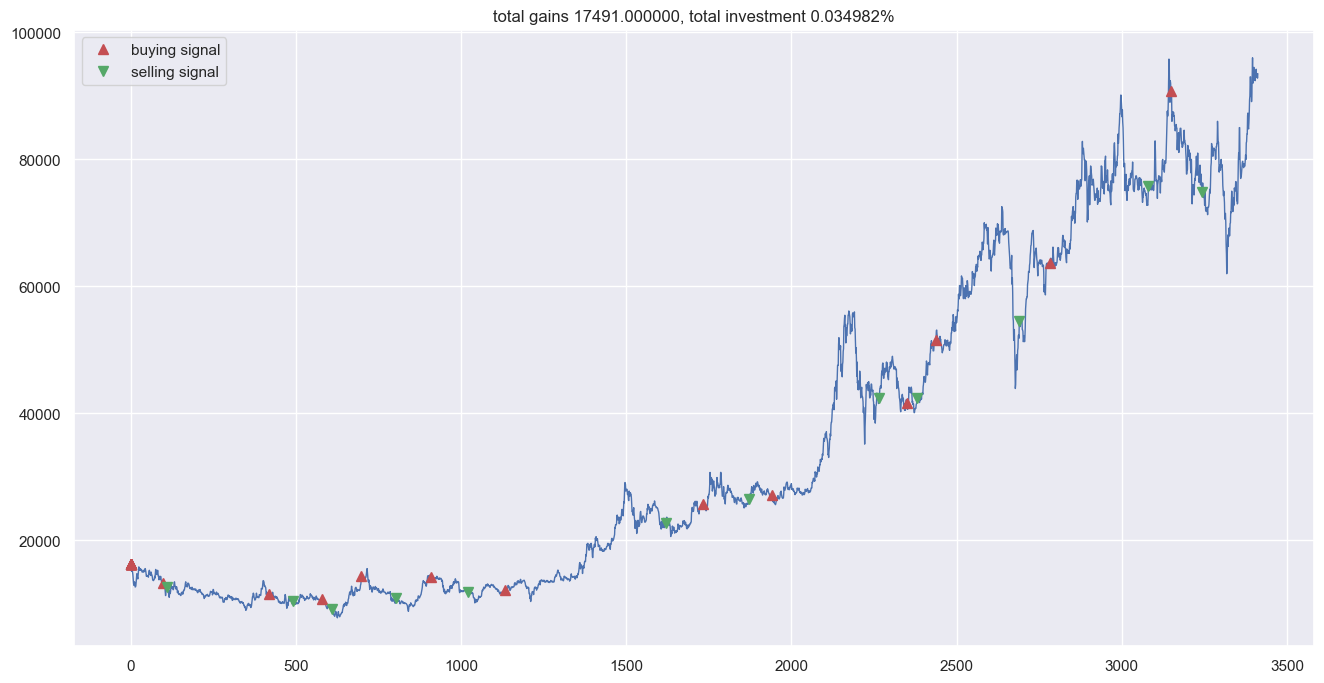

In [8]:
close = df['Close']
fig = plt.figure(figsize = (16,8))
plt.plot(close, color='b', lw=1)
plt.plot(close, '^', markersize=7, color='r', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=7, color='g', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('Trading Point.png')
plt.show()